# Лабораторная работа №1. Милевич Артём ИУ5-23М
### Цель работы
Изучение различных методов визуализация данных и создание истории на основе данных.
### Задание
* Выбрать набор данных (датасет). Вы можете найти список свободно распространяемых датасетов здесь.

Для лабораторных работ не рекомендуется выбирать датасеты очень большого размера.
* Создать "историю о данных" в виде юпитер-ноутбука, с учетом следующих требований:
1) История должна содержать не менее 5 шагов (где 5 - рекомендуемое количество шагов). Каждый шаг содержит график и его текстовую интерпретацию.
2) На каждом шаге наряду с удачным итоговым графиком рекомендуется в юпитер-ноутбуке оставлять результаты предварительных "неудачных" графиков.
3) Не рекомендуется повторять виды графиков, желательно создать 5 графиков различных видов.
4) Выбор графиков должен быть обоснован использованием методологии data-to-viz. Рекомендуется учитывать типичные ошибки построения выбранного вида графика по методологии data-to-viz. Если методология Вами отвергается, то просьба обосновать Ваше решение по выбору графика.
5) История должна содержать итоговые выводы. В реальных "историях о данных" именно эти выводы представляют собой основную ценность для предприятия.

## Ход работы

In [76]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_csv('Online Sales Data.csv')

## Распределение продаж по категориям товаров (Треугольная диаграмма)
Начнем с анализа распределения продаж по различным категориям товаров.

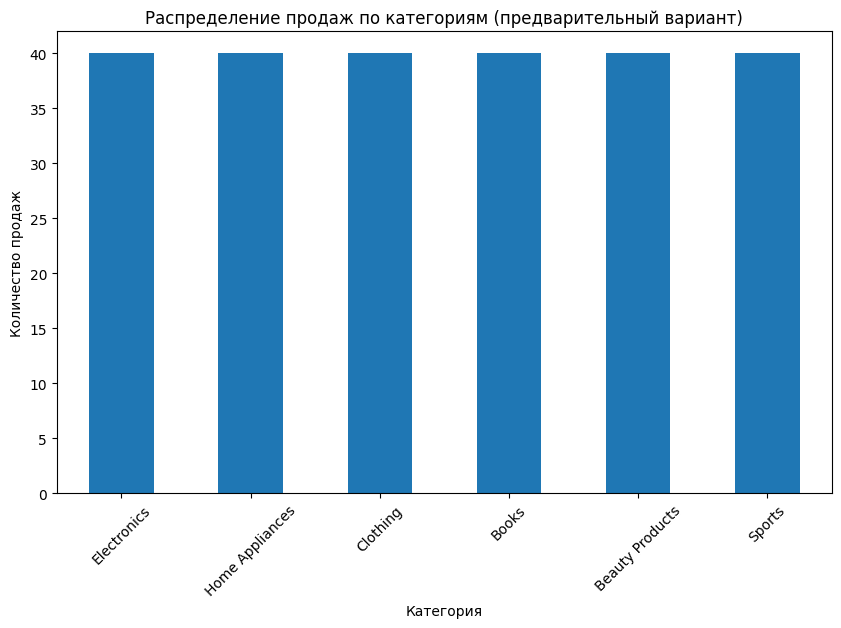

In [77]:
# Предварительный анализ - простой столбчатый график
category_counts = df['Product Category'].value_counts()
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar')
plt.title('Распределение продаж по категориям (предварительный вариант)')
plt.xlabel('Категория')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)
plt.show()

Этот график показывает распределение, но не очень наглядно демонстрирует доли каждой категории в общем объеме продаж.

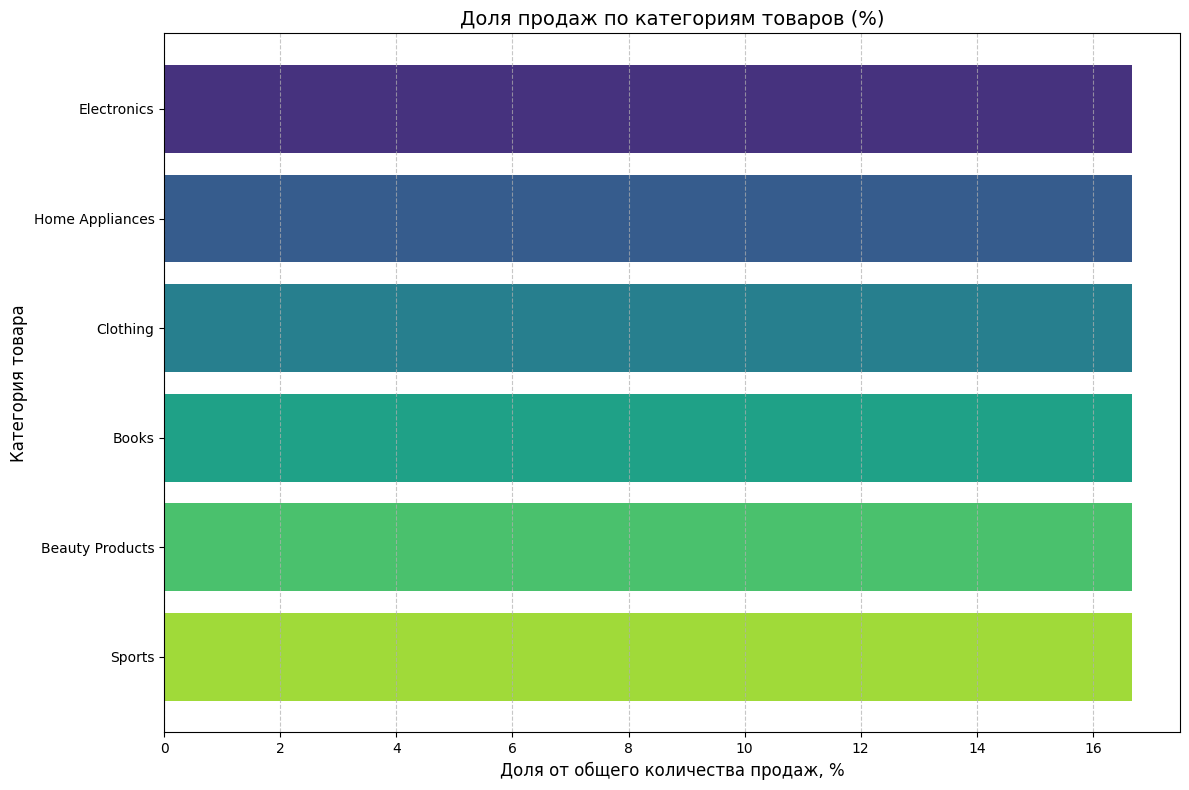

In [78]:
# Улучшенная визуализация - треугольная диаграмма
plt.figure(figsize=(12,8))
category_percent = df['Product Category'].value_counts(normalize=True) * 100
category_percent = category_percent[category_percent > 1]  # Берем только категории с долей >1%

# Сортировка по убыванию и создание треугольной диаграммы
category_percent = category_percent.sort_values(ascending=False)
plt.barh(category_percent.index, category_percent.values, color=sns.color_palette('viridis', len(category_percent)))
plt.title('Доля продаж по категориям товаров (%)', fontsize=14)
plt.xlabel('Доля от общего количества продаж, %', fontsize=12)
plt.ylabel('Категория товара', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Чтобы категория с наибольшей долей была наверху
plt.tight_layout()
plt.show()

График показывает, что все категории занимают одинаковую долю продаж (около 16,7%). Это распределение помогает понять, какие категории наиболее популярны среди покупателей и на какие категории стоит обратить больше внимания при планировании маркетинговых активностей.

## Динамика продаж по месяцам (Линейный график)
Проанализируем, как изменялись продажи с течением времени.

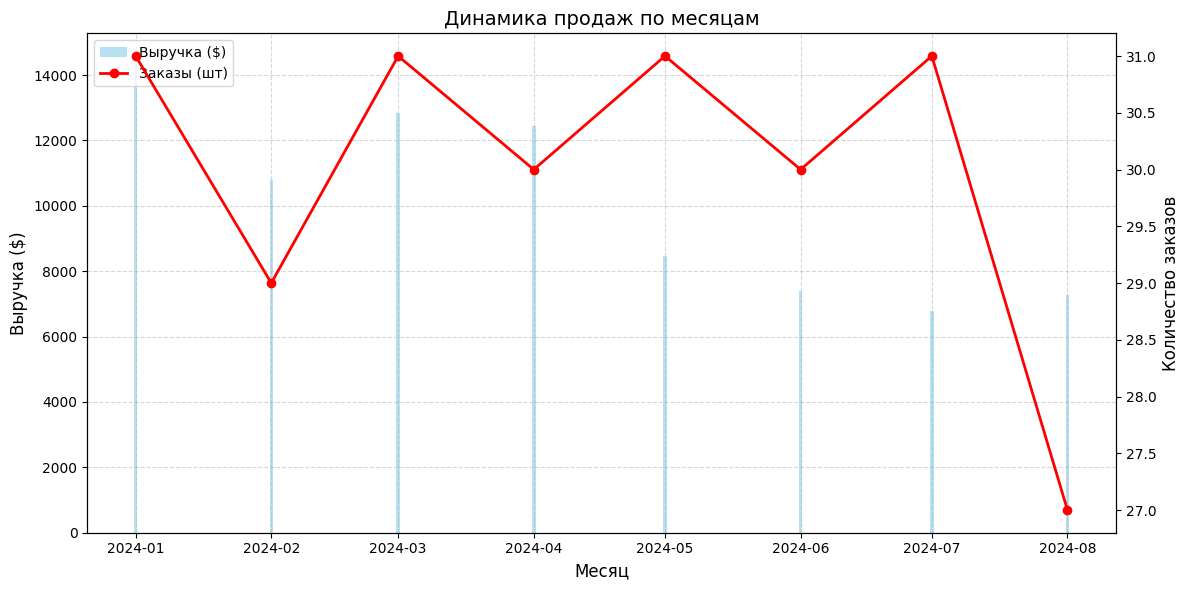

In [79]:
# Преобразуем столбец Date в datetime (если ещё не сделано)
df['Date'] = pd.to_datetime(df['Date'])

# Подготовка данных
df['Month'] = df['Date'].dt.to_period('M')
monthly_sales = df.groupby('Month').agg(
    Total_Orders=('Transaction ID', 'count'),
    Total_Revenue=('Total Revenue', 'sum')
).reset_index()
monthly_sales['Month'] = monthly_sales['Month'].dt.to_timestamp()

# Создаем фигуру и первую ось
fig, ax1 = plt.subplots(figsize=(12, 6))

# График выручки (столбцы)
ax1.bar(monthly_sales['Month'], monthly_sales['Total_Revenue'], 
        color='skyblue', alpha=0.6, label='Выручка ($)')
ax1.set_xlabel('Месяц', fontsize=12)
ax1.set_ylabel('Выручка ($)', fontsize=12)
ax1.grid(linestyle='--', alpha=0.5)

# Создаем вторую ось для количества заказов
ax2 = ax1.twinx()
ax2.plot(monthly_sales['Month'], monthly_sales['Total_Orders'], 
         color='red', marker='o', linewidth=2, label='Заказы (шт)')
ax2.set_ylabel('Количество заказов', fontsize=12)

# Объединяем легенды
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Динамика продаж по месяцам', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Наблюдается динамика, что с мая выручка уменьшилась в среднем на 4000$ и до конца лета так и не дошла до уровня зимы и начала весны.

## Распределение суммы заказов (Гистограмма и boxplot)


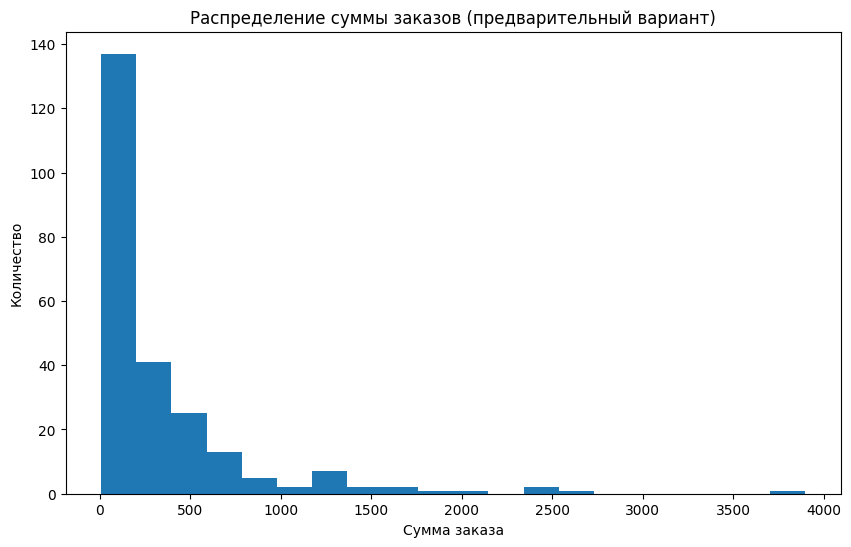

In [80]:
# Предварительный вариант - простая гистограмма
plt.figure(figsize=(10,6))
plt.hist(df['Total Revenue'], bins=20)
plt.title('Распределение суммы заказов (предварительный вариант)')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')
plt.show()

Этот график не очень информативен из-за выбросов, которые "сжимают" основную часть данных.

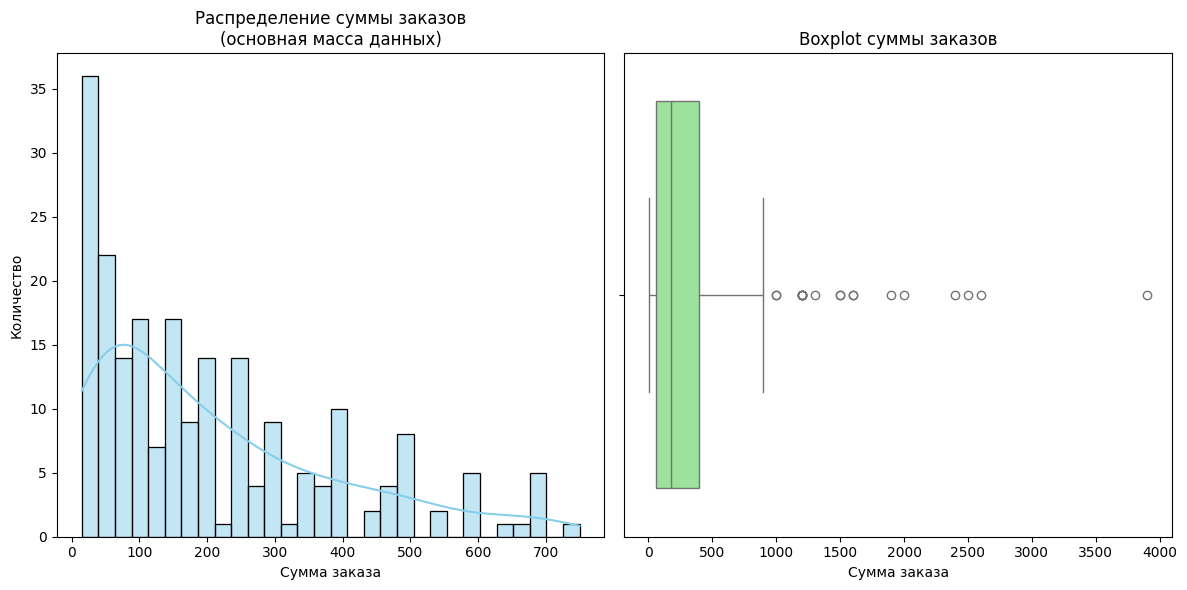

In [81]:
# Улучшенная версия - комбинация гистограммы и boxplot
plt.figure(figsize=(12,6))

# Гистограмма для основной массы данных (исключаем выбросы)
plt.subplot(1, 2, 1)
main_data = df[(df['Total Revenue'] > 10) & (df['Total Revenue'] < 750)]
sns.histplot(main_data['Total Revenue'], bins=30, kde=True, color='skyblue')
plt.title('Распределение суммы заказов\n(основная масса данных)')
plt.xlabel('Сумма заказа')
plt.ylabel('Количество')

# Boxplot для визуализации выбросов
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Total Revenue'], color='lightgreen')
plt.title('Boxplot суммы заказов')
plt.xlabel('Сумма заказа')

plt.tight_layout()
plt.show()

Распределение суммы заказов имеет длинный правый хвост - большинство заказов имеют относительно небольшую сумму (медиана около 120), но есть заказы с большими суммами. Это типичное распределение для розничных продаж. Гистограмма показывает, что наиболее частые суммы заказов находятся в диапазоне 50-150. Наличие выбросов (очень крупных заказов) может указывать на корпоративных клиентов или оптовые покупки. Для бизнеса важно понимать, что хотя крупные заказы редки, они могут составлять значительную часть выручки.

## Связь между категориями товаров и методами оплаты (Тепловая карта)

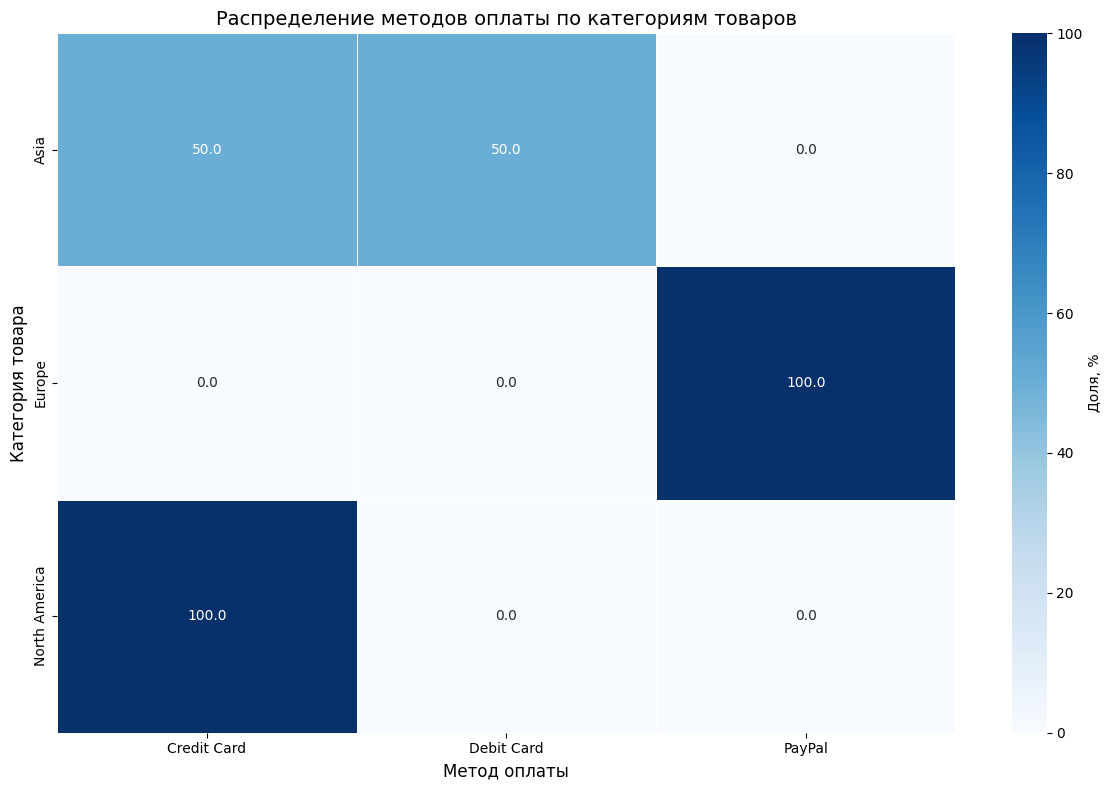

In [82]:
# Создаем кросс-таблицу категорий и методов оплаты
payment_by_category = pd.crosstab(df['Region'], df['Payment Method'], normalize='index') * 100

# Улучшенная версия - тепловая карта
plt.figure(figsize=(12,8))
sns.heatmap(payment_by_category, annot=True, fmt='.1f', cmap='Blues', 
            linewidths=.5, cbar_kws={'label': 'Доля, %'})
plt.title('Распределение методов оплаты по категориям товаров', fontsize=14)
plt.xlabel('Метод оплаты', fontsize=12)
plt.ylabel('Категория товара', fontsize=12)
plt.tight_layout()
plt.show()

Видно, что используются только определённые способы оплаты для Северной Америки и Европы, а в Азии используются кредитные и дебитовые карты одинаково.

## Сравнение среднего чека по способам оплаты (Violin Plot)

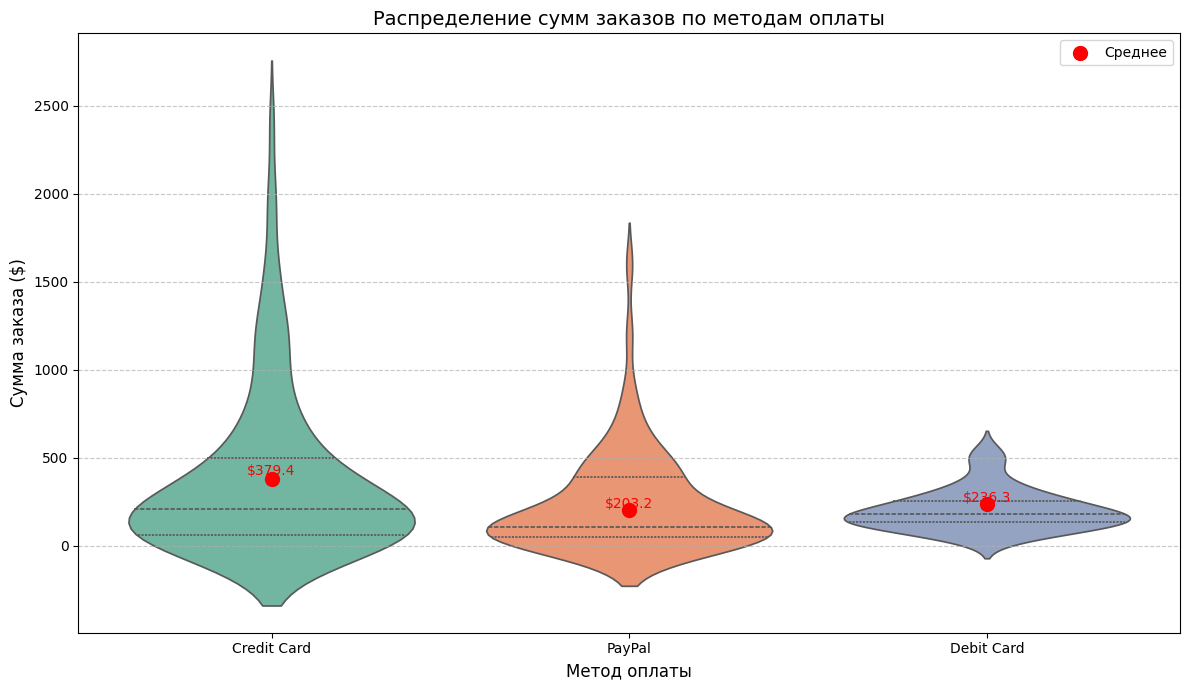

In [83]:
# Фильтруем выбросы (убираем 1% самых крупных заказов)
upper_limit = df['Total Revenue'].quantile(0.99)
filtered_df = df[df['Total Revenue'] <= upper_limit]

# Создаем скрипичную диаграмму
plt.figure(figsize=(12, 7))
sns.violinplot(
    x='Payment Method', 
    y='Total Revenue',
    data=filtered_df,
    palette='Set2',
    inner='quartile'  # Показываем квантили
)

# Добавляем средние значения
means = filtered_df.groupby('Payment Method')['Total Revenue'].mean()
for i, method in enumerate(means.index):
    plt.scatter(i, means[method], color='red', s=100, label='Среднее' if i == 0 else "", zorder=3)

# Настройка отображения
plt.title('Распределение сумм заказов по методам оплаты', fontsize=14)
plt.xlabel('Метод оплаты', fontsize=12)
plt.ylabel('Сумма заказа ($)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем числовые аннотации
for i, method in enumerate(means.index):
    plt.text(i, means[method]*1.05, f'${means[method]:.1f}', 
             ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

Этот график показывает, что средний чек для кредитных карт гораздо больше, чем для PayPal и дебитовых карт

## Вывод
Анализ данных выявил равномерное распределение продаж по категориям (по ~16,7%), сезонное падение выручки летом на 
4000$ и преобладание мелких заказов(50−150) с редкими, но значимыми крупными покупками. Также обнаружены региональные различия в способах оплаты (в Азии равное использование карт, в других регионах – доминирование кредитных и дебитовых карт) и более высокий средний чек при оплате кредитными картами. Эти инсайты помогут оптимизировать ассортимент, платежные системы и маркетинговые стратегии.